In [ ]:
import numpy as np
import random
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
class Card:
    __slots__ = ('rank', 'suit')
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit

class BlackjackEnvironment:
    def __init__(self, num_decks=6, penetration=0.70):
        self.num_decks = num_decks
        self.penetration = penetration
        self.cutoff = None

        # Precomputed value mapping
        self.value_map = {str(i): i for i in range(2, 11)}
        for face in ['jack', 'queen', 'king']:
            self.value_map[face] = 10
        self.value_map['ace'] = 11

        self.deck = []
        self.player_cards = []
        self.dealer_cards = []
        self.has_doubled_down = False
        self.game_over = False
        self.rewards = []
        self.visible_cards = []

        # Undo Hit rule variables
        self.undo_available = False
        self.undo_used = False
        self.pre_hit_state = None

        self.reset_game()

    def _create_new_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        ranks = [str(i) for i in range(2, 11)] + ['jack', 'queen', 'king', 'ace']
        return [Card(rank, suit) for rank in ranks for suit in suits] * self.num_decks

    def _draw_random_card(self):
        if len(self.deck) < 20:  # Reshuffle if deck is too small
            self.deck = self._create_new_deck()
            random.shuffle(self.deck)
            self.cutoff = int(len(self.deck) * self.penetration)
        card = self.deck.pop()
        self.visible_cards.append(card)
        return card

    def reset_game(self):
        if not self.deck or len(self.deck) < (52 * self.num_decks * (1 - self.penetration)):
            self.deck = self._create_new_deck()
            random.shuffle(self.deck)
            self.cutoff = int(len(self.deck) * self.penetration)

        self.player_cards = [self._draw_random_card(), self._draw_random_card()]
        self.dealer_cards = [self._draw_random_card(), self._draw_random_card()]
        self.has_doubled_down = False
        self.game_over = False
        self.rewards = []
        self.visible_cards = self.player_cards.copy() + [self.dealer_cards[0]]

        # Reset Undo Hit state
        self.undo_available = False
        self.undo_used = False
        self.pre_hit_state = None

        return self.get_current_state()

    def _get_card_value(self, card):
        return self.value_map[card.rank]

    def _calculate_hand_value(self, hand):
        total = 0
        ace_count = 0

        for card in hand:
            if card.rank == 'ace':
                ace_count += 1
                total += 11
            else:
                total += self._get_card_value(card)

        while total > 21 and ace_count > 0:
            total -= 10
            ace_count -= 1

        return total

    def _has_soft_hand(self, hand):
        total = self._calculate_hand_value(hand)
        has_ace = any(card.rank == 'ace' for card in hand)
        return has_ace and total <= 21 and (total - 10) < 11

    def _check_if_busted(self, hand):
        return self._calculate_hand_value(hand) > 21

    def _check_natural_blackjack(self, hand):
        return (len(hand) == 2 and
                self._calculate_hand_value(hand) == 21 and
                any(card.rank == 'ace' for card in hand) and
                any(card.rank in ['10', 'jack', 'queen', 'king'] for card in hand))

    def _play_dealer_hand(self):
        # This is the "Stand on Soft 17" rule. The dealer stands on any 17.
        while self._calculate_hand_value(self.dealer_cards) < 17:
            self.dealer_cards.append(self._draw_random_card())

    def _finalize_round(self):
        player_value = self._calculate_hand_value(self.player_cards)
        dealer_value = self._calculate_hand_value(self.dealer_cards)

        if self._check_if_busted(self.dealer_cards):
            reward = 2 if self.has_doubled_down else 1
            self.rewards.append(reward)
            return 'terminal', reward, True

        if player_value > dealer_value:
            reward = 2 if self.has_doubled_down else 1
        elif player_value < dealer_value:
            reward = -2 if self.has_doubled_down else -1
        else:
            reward = 0

        self.rewards.append(reward)
        return 'terminal', reward, True

    def get_current_state(self):
        player_value = self._calculate_hand_value(self.player_cards)
        dealer_up_card_value = self._get_card_value(self.dealer_cards[0])
        is_soft = self._has_soft_hand(self.player_cards)

        # State tuple without Smart Draw variables
        return (player_value, dealer_up_card_value, is_soft,
                self.has_doubled_down,
                self.undo_available,
                self.undo_used)

    def step(self, action):
        if self.game_over:
            return 'terminal', 0, True

        # Reset undo availability for non-hit/undo actions
        if action not in ['h', 'u']:
            self.undo_available = False

        # Handle Undo Hit action
        if action == 'u':  # 'u' for "undo hit"
            if self.undo_available and not self.undo_used and self.pre_hit_state:
                # Restore game state to before the last hit
                self.player_cards = self.pre_hit_state['player_cards']
                self.deck = self.pre_hit_state['deck']
                self.visible_cards = self.pre_hit_state['visible_cards']
                self.has_doubled_down = self.pre_hit_state['has_doubled_down']

                self.undo_available = False
                self.undo_used = True
                return self.get_current_state(), 0, False

        # Check for natural blackjack
        if self._check_natural_blackjack(self.player_cards):
            dealer_blackjack = self._check_natural_blackjack(self.dealer_cards)
            reward = 0 if dealer_blackjack else 1.5
            self.rewards.append(reward)
            self.game_over = True
            return 'terminal', reward, True

        if action == 'h':
            # Save state before hitting for possible undo
            if not self.undo_used:
                self.pre_hit_state = {
                    'player_cards': self.player_cards.copy(),
                    'deck': self.deck.copy(),
                    'visible_cards': self.visible_cards.copy(),
                    'has_doubled_down': self.has_doubled_down,
                }
                self.undo_available = True

            # Draw card and add to player's hand
            card = self._draw_random_card()
            self.player_cards.append(card)

            # Check for bust
            if self._check_if_busted(self.player_cards):
                reward = -2 if self.has_doubled_down else -1
                self.rewards.append(reward)
                self.game_over = True
                self.undo_available = False  # Bust prevents undo
                return 'terminal', reward, True

            return self.get_current_state(), 0, False

        elif action == 's':
            self._play_dealer_hand()
            return self._finalize_round()

        elif action == 'd':
            if not self.has_doubled_down and len(self.player_cards) == 2:
                self.has_doubled_down = True
                card = self._draw_random_card()
                self.player_cards.append(card)

                if self._check_if_busted(self.player_cards):
                    reward = -2
                    self.rewards.append(reward)
                    self.game_over = True
                    return 'terminal', reward, True

                self._play_dealer_hand()
                return self._finalize_round()
            else:
                # Invalid double down - treat as stand
                self._play_dealer_hand()
                return self._finalize_round()

        else:
            raise ValueError(f"Invalid action: {action}")

    # def get_true_count(self):
    #     """Calculate true count using Hi-Lo system"""
    #     count = 0
    #     for card in self.visible_cards:
    #         if card.rank in ['2', '3', '4', '5', '6']:
    #             count += 1
    #         elif card.rank in ['10', 'jack', 'queen', 'king', 'ace']:
    #             count -= 1

    #     # Estimate remaining decks
    #     remaining_cards = len(self.deck)
    #     remaining_decks = remaining_cards / 52
    #     return count / max(remaining_decks, 0.5)  # Avoid division by zero

#Basic Strategy

In [ ]:
class BasicStrategyAgent:
    def __init__(self):
        # Charts for S17, Double on any 2 cards
        # H=Hit, S=Stand, D=Double Down
        self.hard_total_strategy = {
            20: {k: 'S' for k in range(2, 12)},
            19: {k: 'S' for k in range(2, 12)},
            18: {k: 'S' for k in range(2, 12)},
            17: {k: 'S' for k in range(2, 12)},
            16: {k: 'S' if k in range(2, 7) else 'H' for k in range(2, 12)},
            15: {k: 'S' if k in range(2, 7) else 'H' for k in range(2, 12)},
            14: {k: 'S' if k in range(2, 7) else 'H' for k in range(2, 12)},
            13: {k: 'S' if k in range(2, 7) else 'H' for k in range(2, 12)},
            12: {k: 'S' if k in range(4, 7) else 'H' for k in range(2, 12)},
            11: {k: 'D' for k in range(2, 12)},
            10: {k: 'D' if k in range(2, 10) else 'H' for k in range(2, 12)},
            9:  {k: 'D' if k in range(3, 7) else 'H' for k in range(2, 12)},
            8:  {k: 'H' for k in range(2, 12)},
            7:  {k: 'H' for k in range(2, 12)},
            6:  {k: 'H' for k in range(2, 12)},
            5:  {k: 'H' for k in range(2, 12)},
        }

        self.soft_total_strategy = {
            20: {k: 'S' for k in range(2, 12)}, # A, 9
            19: {k: 'S' for k in range(2, 12)}, # A, 8
            18: {k: 'D' if k in range(2, 7) else 'S' for k in range(2, 12)}, # A, 7
            17: {k: 'D' if k in range(3, 7) else 'H' for k in range(2, 12)}, # A, 6
            16: {k: 'D' if k in range(4, 7) else 'H' for k in range(2, 12)}, # A, 5
            15: {k: 'D' if k in range(4, 7) else 'H' for k in range(2, 12)}, # A, 4
            14: {k: 'D' if k in range(5, 7) else 'H' for k in range(2, 12)}, # A, 3
            13: {k: 'D' if k in range(5, 7) else 'H' for k in range(2, 12)}, # A, 2
        }

    def select_action(self, state, player_hand_size):
        player_value, dealer_up_card, is_soft, has_doubled_down, _, _ = state

        can_double_down = (player_hand_size == 2) and not has_doubled_down

        action = 'S' # Default action
        if is_soft:
            # Player value for soft hands in our chart is Ace + other card(s)
            # A soft 13 is an A and a 2, so its value is 13.
            action = self.soft_total_strategy.get(player_value, {}).get(dealer_up_card, 'S')
        else:
            # Clamp player value to the max key in the hard chart
            player_val_key = min(player_value, 20)
            action = self.hard_total_strategy.get(player_val_key, {}).get(dealer_up_card, 'S')

        if action == 'D' and not can_double_down:
            action = 'H'

        return action.lower() # return 'h', 's', or 'd'

In [ ]:
class Q_learning:
    def __init__(self, learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0):

        self.q_table = {}
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate

        # Use Basic Strategy as a baseline to guide initial exploration
        self.basic_strategy_agent = BasicStrategyAgent()

    def _get_q_value(self, state, action):
        """Safely gets a Q-value from the table, defaulting to 0."""
        return self.q_table.get((state, action), 0.0)

    def select_action(self, state, env):
        """
        Selects an action using an epsilon-greedy strategy, respecting game rules.
        """
        # Define all possible valid actions from the current state
        valid_actions = ['h', 's']
        # Double down is only possible with two cards and if not already doubled
        if len(env.player_cards) == 2 and not state[3]: # state[3] is has_doubled_down
            valid_actions.append('d')
        # Undo is only possible if the flag is set
        if state[4] and not state[5]: # state[4] is undo_available, state[5] is undo_used
            valid_actions.append('u')

        # Exploration vs. Exploitation
        if np.random.random() < self.epsilon:
            # --- Explore ---
            return np.random.choice(valid_actions)
        else:
            # --- Exploit ---
            q_values = {action: self._get_q_value(state, action) for action in valid_actions}

            # If all Q-values for the state are the same (e.g., all 0 for a new state),
            # fall back to the basic strategy to make a reasonable choice.
            if len(set(q_values.values())) == 1:
                return self.basic_strategy_agent.select_action(state, len(env.player_cards))

            # Otherwise, choose the action with the highest Q-value
            return max(q_values, key=q_values.get)

    def update(self, state, action, reward, next_state, done):
        """
        Updates the Q-table using the Bellman equation after a step.
        """
        # Get the current Q-value
        old_value = self._get_q_value(state, action)

        # Find the max Q-value for the next state
        if done:
            next_max = 0.0
        else:
            # Consider all possible actions in the next state to find the max Q-value
            possible_next_actions = ['h', 's', 'd', 'u']
            next_q_values = [self._get_q_value(next_state, act) for act in possible_next_actions]
            next_max = max(next_q_values)

        # Q-learning formula
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
        self.q_table[(state, action)] = new_value

Starting training for 500,000 episodes...
  ...trained 50,000 episodes | Epsilon: 0.7788
  ...trained 100,000 episodes | Epsilon: 0.6065
  ...trained 150,000 episodes | Epsilon: 0.4724
  ...trained 200,000 episodes | Epsilon: 0.3679
  ...trained 250,000 episodes | Epsilon: 0.2865
  ...trained 300,000 episodes | Epsilon: 0.2231
  ...trained 350,000 episodes | Epsilon: 0.1738
  ...trained 400,000 episodes | Epsilon: 0.1353
  ...trained 450,000 episodes | Epsilon: 0.1054
  ...trained 500,000 episodes | Epsilon: 0.0821

✅ Training complete.

🔬 Evaluating learned policy...

--- Q-Learning Agent Performance Results ---
Simulated 400,000 hands.
Return to Player (RTP): 97.9609%
House Edge: 2.0391%

--- Game Outcomes ---
Wins:   42.81%
Losses: 48.07%
Pushes: 9.13%

--- Rule Variation Usage ---
Undo Hit Used: 119,422 times
Undo Rate:     In 29.86% of all hands

📊 Generating plots...


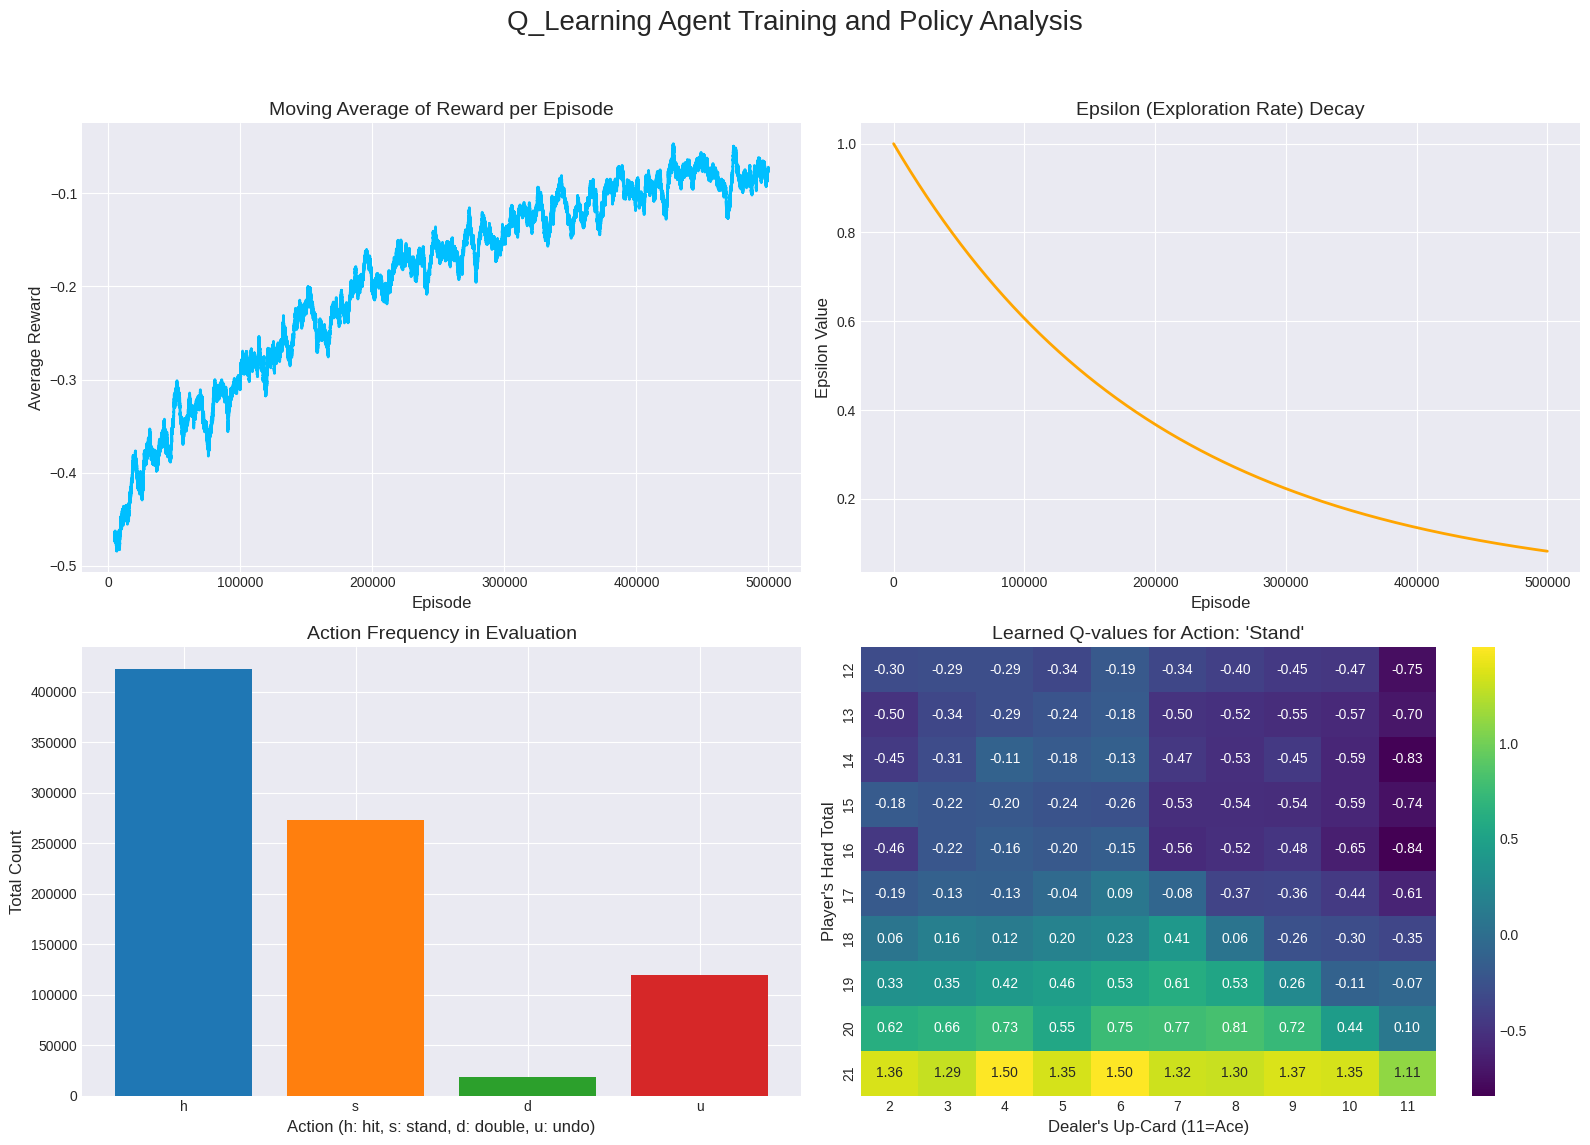

In [ ]:
def evaluate_policy(agent, env, num_episodes=100000):
    """
    Evaluates the agent's policy and counts action frequency.
    """
    agent.epsilon = 0.0
    total_reward, total_wager = 0.0, 0
    outcomes = {'wins': 0, 'losses': 0, 'pushes': 0}
    action_counts = {'h': 0, 's': 0, 'd': 0, 'u': 0}

    for _ in range(num_episodes):
        state = env.reset_game()
        done = False
        wager = 1
        if env._check_natural_blackjack(env.player_cards):
            _, reward, done = env.step('s')

        while not done:
            action = agent.select_action(state, env)
            action_counts[action] += 1
            if action == 'd': wager = 2
            next_state, reward, done = env.step(action)
            state = next_state

        total_reward += reward
        total_wager += wager
        if reward > 0: outcomes['wins'] += 1
        elif reward < 0: outcomes['losses'] += 1
        else: outcomes['pushes'] += 1

    rtp = (total_wager + total_reward) / total_wager
    return {
        "episodes": num_episodes, "rtp": rtp, "house_edge": 1 - rtp,
        "win_rate": outcomes['wins'] / num_episodes,
        "loss_rate": outcomes['losses'] / num_episodes,
        "push_rate": outcomes['pushes'] / num_episodes,
        "action_counts": action_counts,
    }


def plot_results(rewards, epsilons, metrics, agent):
    """
    Generates and displays a single figure with all plots.
    """
    print("\n📊 Generating plots...")
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Q_Learning Agent Training and Policy Analysis', fontsize=20)

    # 1. Moving Average of Rewards
    ax1 = axes[0, 0]
    reward_series = pd.Series(rewards)
    moving_avg = reward_series.rolling(window=max(1, len(rewards)//100)).mean()
    ax1.plot(moving_avg, color='deepskyblue', linewidth=2)
    ax1.set_title('Moving Average of Reward per Episode', fontsize=14)
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Average Reward', fontsize=12)

    # 2. Epsilon Decay
    ax2 = axes[0, 1]
    ax2.plot(epsilons, color='orange', linewidth=2)
    ax2.set_title('Epsilon (Exploration Rate) Decay', fontsize=14)
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Epsilon Value', fontsize=12)

    # 3. Action Selection Frequency
    ax3 = axes[1, 0]
    actions = list(metrics['action_counts'].keys())
    counts = list(metrics['action_counts'].values())
    ax3.bar(actions, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax3.set_title('Action Frequency in Evaluation', fontsize=14)
    ax3.set_xlabel('Action (h: hit, s: stand, d: double, u: undo)', fontsize=12)
    ax3.set_ylabel('Total Count', fontsize=12)

    # 4. Q-value Heatmap for 'Stand' action
    ax4 = axes[1, 1]
    player_totals = range(12, 22)
    dealer_cards = range(2, 12)
    q_values = np.zeros((len(player_totals), len(dealer_cards)))
    for i, p_total in enumerate(player_totals):
        for j, d_card in enumerate(dealer_cards):
            state = (p_total, d_card, False, False, False, False)
            q_values[i, j] = agent._get_q_value(state, 's')
    sns.heatmap(q_values, ax=ax4, xticklabels=dealer_cards, yticklabels=player_totals, cmap='viridis', annot=True, fmt=".2f")
    ax4.set_title("Learned Q-values for Action: 'Stand'", fontsize=14)
    ax4.set_xlabel("Dealer's Up-Card (11=Ace)", fontsize=12)
    ax4.set_ylabel("Player's Hard Total", fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


if __name__ == "__main__":
    env = BlackjackEnvironment(num_decks=6)
    agent = Q_learning(learning_rate=0.01, discount_factor=0.95, exploration_rate=1.0)

    num_training_episodes = 500_000
    min_epsilon = 0.05
    epsilon_decay = 0.999995

    rewards_per_episode, epsilon_history = [], []

    print(f"Starting training for {num_training_episodes:,} episodes...")
    for episode in range(num_training_episodes):
        state = env.reset_game()
        done = False
        episode_reward = 0

        while not done:
            action = agent.select_action(state, env)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

        rewards_per_episode.append(episode_reward)
        epsilon_history.append(agent.epsilon)

        if agent.epsilon > min_epsilon:
            agent.epsilon *= epsilon_decay
        if (episode + 1) % 50000 == 0:
            print(f"  ...trained {episode + 1:,} episodes | Epsilon: {agent.epsilon:.4f}")

    print("\n✅ Training complete.")

    print("\n🔬 Evaluating learned policy...")
    final_metrics = evaluate_policy(agent, env, num_episodes=400_000)

    # --- Print Text-Based Results ---
    print("\n--- Q-Learning Agent Performance Results ---")
    print(f"Simulated {final_metrics['episodes']:,} hands.")
    print(f"Return to Player (RTP): {final_metrics['rtp']:.4%}")
    print(f"House Edge: {final_metrics['house_edge']:.4%}")
    print("\n--- Game Outcomes ---")
    print(f"Wins:   {final_metrics['win_rate']:.2%}")
    print(f"Losses: {final_metrics['loss_rate']:.2%}")
    print(f"Pushes: {final_metrics['push_rate']:.2%}")
    undo_rate = final_metrics['action_counts']['u'] / final_metrics['episodes']
    print("\n--- Rule Variation Usage ---")
    print(f"Undo Hit Used: {final_metrics['action_counts']['u']:,} times")
    print(f"Undo Rate:     In {undo_rate:.2%} of all hands")

    # --- Generate and Show Combined Plot ---
    plot_results(rewards_per_episode, epsilon_history, final_metrics, agent)

In [ ]:
class SARSA_Agent:
    def __init__(self, learning_rate=0.01, discount_factor=0.95, exploration_rate=1.0):
        """
        Initializes a SARSA agent.

        Args:
            learning_rate (float): Alpha, the rate at which the agent learns.
            discount_factor (float): Gamma, the importance of future rewards.
            exploration_rate (float): Epsilon, the initial probability of choosing a random action.
        """
        self.q_table = {}
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate

        # Use Basic Strategy as a baseline to guide initial exploration
        self.basic_strategy_agent = BasicStrategyAgent()

    def _get_q_value(self, state, action):
        """Safely gets a Q-value from the table, defaulting to 0."""
        return self.q_table.get((state, action), 0.0)

    def select_action(self, state, env):

        valid_actions = ['h', 's']
        if len(env.player_cards) == 2 and not state[3]: # has_doubled_down
            valid_actions.append('d')
        if state[4] and not state[5]: # undo_available and not undo_used
            valid_actions.append('u')

        if np.random.random() < self.epsilon:
            return np.random.choice(valid_actions)
        else:
            q_values = {action: self._get_q_value(state, action) for action in valid_actions}
            if len(set(q_values.values())) == 1:
                return self.basic_strategy_agent.select_action(state, len(env.player_cards))
            return max(q_values, key=q_values.get)

    def update(self, state, action, reward, next_state, next_action, done):
        """
        Updates the Q-table using the SARSA update rule.

        Note: Requires the action that will be taken in the next state.
        """
        old_value = self._get_q_value(state, action)

        # Get the Q-value for the *actual* next state-action pair
        if done:
            next_q_value = 0.0
        else:
            next_q_value = self._get_q_value(next_state, next_action)

        # SARSA update formula
        new_value = old_value + self.alpha * (reward + self.gamma * next_q_value - old_value)
        self.q_table[(state, action)] = new_value

Starting SARSA training for 500,000 episodes...
  ...trained 50,000 episodes | Epsilon: 0.7788
  ...trained 100,000 episodes | Epsilon: 0.6065
  ...trained 150,000 episodes | Epsilon: 0.4724
  ...trained 200,000 episodes | Epsilon: 0.3679
  ...trained 250,000 episodes | Epsilon: 0.2865
  ...trained 300,000 episodes | Epsilon: 0.2231
  ...trained 350,000 episodes | Epsilon: 0.1738
  ...trained 400,000 episodes | Epsilon: 0.1353
  ...trained 450,000 episodes | Epsilon: 0.1054
  ...trained 500,000 episodes | Epsilon: 0.0821

✅ Training complete.

🔬 Evaluating learned policy...

--- SARSA Agent Performance Results ---
Simulated 400,000 hands.
Return to Player (RTP): 97.6648%
House Edge: 2.3352%

--- Game Outcomes ---
Wins:   42.98%
Losses: 48.15%
Pushes: 8.87%

--- Rule Variation Usage ---
Undo Hit Used: 86,087 times
Undo Rate:     In 21.52% of all hands

 Generating plots...


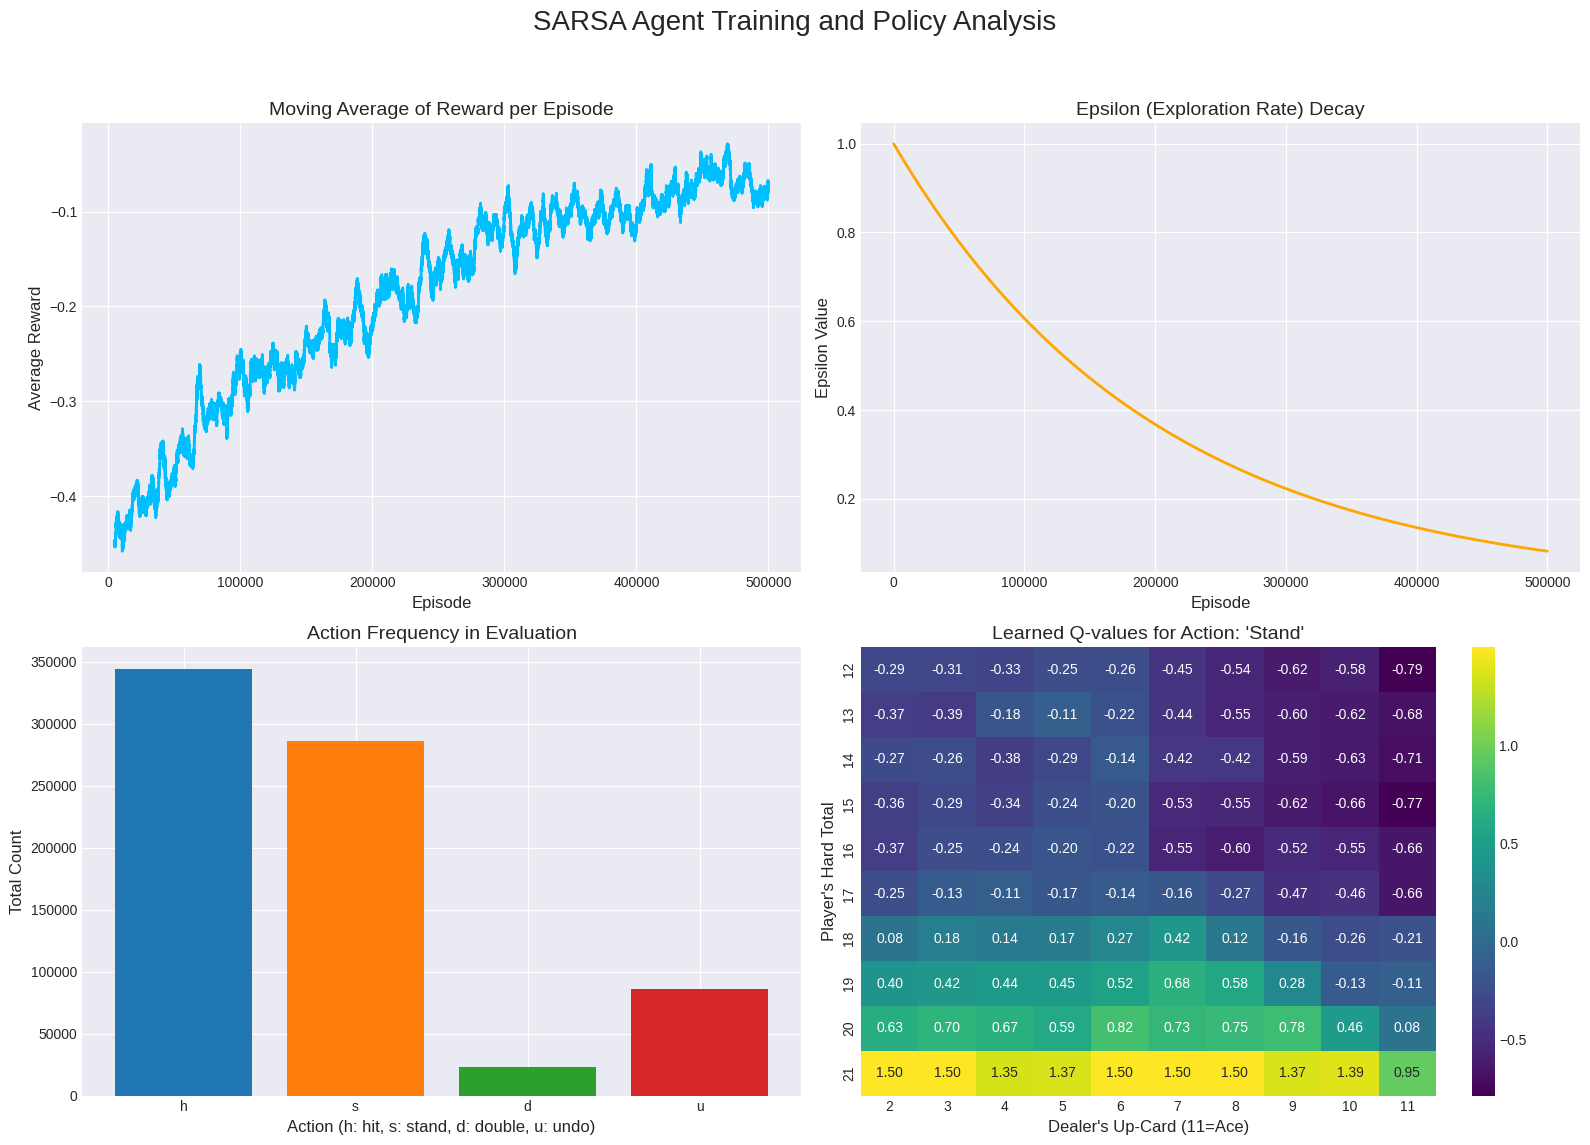

In [ ]:
def evaluate_policy(agent, env, num_episodes=100000):
    agent.epsilon = 0.0  # Turn off exploration for evaluation
    total_reward, total_wager = 0.0, 0
    outcomes = {'wins': 0, 'losses': 0, 'pushes': 0}
    action_counts = {'h': 0, 's': 0, 'd': 0, 'u': 0}

    for _ in range(num_episodes):
        state = env.reset_game()
        done = False
        wager = 1
        if env._check_natural_blackjack(env.player_cards):
            _, reward, done = env.step('s')

        while not done:
            action = agent.select_action(state, env)
            action_counts[action] += 1
            if action == 'd':
                wager = 2
            next_state, reward, done = env.step(action)
            state = next_state

        total_reward += reward
        total_wager += wager
        if reward > 0:
            outcomes['wins'] += 1
        elif reward < 0:
            outcomes['losses'] += 1
        else:
            outcomes['pushes'] += 1

    rtp = (total_wager + total_reward) / total_wager
    return {
        "episodes": num_episodes, "rtp": rtp, "house_edge": 1 - rtp,
        "win_rate": outcomes['wins'] / num_episodes,
        "loss_rate": outcomes['losses'] / num_episodes,
        "push_rate": outcomes['pushes'] / num_episodes,
        "action_counts": action_counts,
    }

def plot_results(rewards, epsilons, metrics, agent):
    """
    Generates and displays a single figure with all plots for analysis.
    """
    print("\n Generating plots...")
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('SARSA Agent Training and Policy Analysis', fontsize=20)

    # Plot 1: Moving Average of Rewards
    reward_series = pd.Series(rewards)
    moving_avg = reward_series.rolling(window=max(1, len(rewards)//100)).mean()
    axes[0, 0].plot(moving_avg, color='deepskyblue', linewidth=2)
    axes[0, 0].set_title('Moving Average of Reward per Episode', fontsize=14)
    axes[0, 0].set_xlabel('Episode', fontsize=12)
    axes[0, 0].set_ylabel('Average Reward', fontsize=12)

    # Plot 2: Epsilon Decay
    axes[0, 1].plot(epsilons, color='orange', linewidth=2)
    axes[0, 1].set_title('Epsilon (Exploration Rate) Decay', fontsize=14)
    axes[0, 1].set_xlabel('Episode', fontsize=12)
    axes[0, 1].set_ylabel('Epsilon Value', fontsize=12)

    # Plot 3: Action Selection Frequency
    actions = list(metrics['action_counts'].keys())
    counts = list(metrics['action_counts'].values())
    axes[1, 0].bar(actions, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[1, 0].set_title('Action Frequency in Evaluation', fontsize=14)
    axes[1, 0].set_xlabel('Action (h: hit, s: stand, d: double, u: undo)', fontsize=12)
    axes[1, 0].set_ylabel('Total Count', fontsize=12)

    # Plot 4: Q-value Heatmap for 'Stand' action
    player_totals = range(12, 22); dealer_cards = range(2, 12)
    q_values = np.zeros((len(player_totals), len(dealer_cards)))
    for i, p_total in enumerate(player_totals):
        for j, d_card in enumerate(dealer_cards):
            state = (p_total, d_card, False, False, False, False)
            q_values[i, j] = agent._get_q_value(state, 's')
    sns.heatmap(q_values, ax=axes[1, 1], xticklabels=dealer_cards, yticklabels=player_totals, cmap='viridis', annot=True, fmt=".2f")
    axes[1, 1].set_title("Learned Q-values for Action: 'Stand'", fontsize=14)
    axes[1, 1].set_xlabel("Dealer's Up-Card (11=Ace)", fontsize=12)
    axes[1, 1].set_ylabel("Player's Hard Total", fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

if __name__ == "__main__":
    env = BlackjackEnvironment(num_decks=6)
    agent = SARSA_Agent(learning_rate=0.01, discount_factor=0.95, exploration_rate=1.0)

    num_training_episodes = 500_000
    min_epsilon = 0.005
    epsilon_decay = 0.999995
    rewards_per_episode, epsilon_history = [], []

    print(f"Starting SARSA training for {num_training_episodes:,} episodes...")
    for episode in range(num_training_episodes):
        state = env.reset_game()
        action = agent.select_action(state, env)
        done = False
        episode_reward = 0

        while not done:
            next_state, reward, done = env.step(action)
            # Choose the next action from the next state *before* updating
            next_action = agent.select_action(next_state, env) if not done else None
            # Update Q-table using the S-A-R-S-A tuple
            agent.update(state, action, reward, next_state, next_action, done)
            # Move to the next state and action
            state = next_state
            action = next_action
            episode_reward += reward

        rewards_per_episode.append(episode_reward)
        epsilon_history.append(agent.epsilon)

        if agent.epsilon > min_epsilon:
            agent.epsilon *= epsilon_decay
        if (episode + 1) % 50000 == 0:
            print(f"  ...trained {episode + 1:,} episodes | Epsilon: {agent.epsilon:.4f}")

    print("\n✅ Training complete.")

    print("\n🔬 Evaluating learned policy...")
    final_metrics = evaluate_policy(agent, env, num_episodes=400_000)

    # --- Print Text-Based Results ---
    print("\n--- SARSA Agent Performance Results ---")
    print(f"Simulated {final_metrics['episodes']:,} hands.")
    print(f"Return to Player (RTP): {final_metrics['rtp']:.4%}")
    print(f"House Edge: {final_metrics['house_edge']:.4%}")
    print("\n--- Game Outcomes ---")
    print(f"Wins:   {final_metrics['win_rate']:.2%}")
    print(f"Losses: {final_metrics['loss_rate']:.2%}")
    print(f"Pushes: {final_metrics['push_rate']:.2%}")
    undo_rate = final_metrics['action_counts']['u'] / final_metrics['episodes']
    print("\n--- Rule Variation Usage ---")
    print(f"Undo Hit Used: {final_metrics['action_counts']['u']:,} times")
    print(f"Undo Rate:     In {undo_rate:.2%} of all hands")

    # --- Generate and Show Combined Plot ---
    plot_results(rewards_per_episode, epsilon_history, final_metrics, agent)